# 🏦 GESTÃO DE RISCO: MODELO DE SCORING BASILEIA (PD)
**Mesa de Operações:** Risco de Crédito Comercial
**Objetivo:** Calcular a Probabilidade de Default (PD) para o cálculo da Perda Esperada ($EL = PD \times LGD \times EAD$).

## 1. Setup e Governança de Infraestrutura
Este bloco inicializa o radar de navegação e a blindagem do código.
* **Hot Reload (`%autoreload`):** Mitiga o Risco Operacional de memória em cache. Permite que o Jupyter leia atualizações na biblioteca central (`src/`) em tempo real, sem necessidade de reiniciar o servidor (Zero Downtime).
* **Isolamento de Domínio (`src/`):** A matemática pesada e as regras de negócio foram encapsuladas fora do Notebook para garantir rastreabilidade e evitar execução de células fora de ordem.

In [1]:
# 1. Ativa o radar de atualização em tempo real (Hot Reload)
%load_ext autoreload
%autoreload 2

# Visor, GPS e Conexão 
import sys, pandas as pd
from pathlib import Path
import numpy as np



# Configura o visor financeiro
pd.options.display.max_columns = None
pd.options.display.float_format = '{:.4f}'.format

# GPS Dinâmico e Blindado: Acha a raiz do projeto automaticamente
raiz = Path.cwd() if Path.cwd().joinpath('src').exists() else Path.cwd().parent
sys.path.append(str(raiz))

# Conecta os motores
from src.data_ingestion import carregar_base_basileia
from src.feature_engineering import (
    calcular_historico_credito, 
    padronizar_tempo_emprego, 
    criar_variaveis_dummy, 
    imputar_dados_nulos, 
    remover_colunas_toxicas, 
    definir_variavel_alvo, 
    dividir_treino_teste
)
from src.woe_iv import calcular_woe_iv
from src.plots_woe import auditar_tendencia_woe

print(f"STATUS: Cockpit alinhado. Rota travada em: {raiz}")

STATUS: Cockpit alinhado. Rota travada em: C:\Users\igorc\OneDrive\Área de Trabalho\basel_risk_modeling


## 2. Esteira ETL e Engenharia de Variáveis (Feature Engineering)
Este é o motor principal de tratamento de dados. Ele extrai a base bruta e a transforma em uma matriz matemática de risco.

**Fundamentos Matemáticos e de Negócio:**
1. **Remoção de Ativos Tóxicos:** Variáveis com mais de 50% de dados nulos (NaN) são sumariamente ejetadas (Drop). Tentar imputar dados com esse nível de ausência configuraria fraude estatística (distorção severa da variância).
2. **Prevenção de Data Leakage (Vazamento de Dados):** A variável original `loan_status` é excluída da base. Se mantida, o algoritmo usaria o futuro (o calote já consumado) para prever o passado, gerando uma correlação espúria perfeita ($R^2 = 1$).
3. **A Bússola de Risco (Target):** Criação da variável binária `good_bad_loan` operando em baixo nível via `np.where`.
   * **1 (Lucro):** Clientes adimplentes (Current, Fully Paid).
   * **0 (Loss / PD):** Clientes em default (Charged Off, Late > 31 dias). Representam o alvo da nossa modelagem.

In [2]:
# A Execução do ETL
print("STATUS: Iniciando esteira de processamento...")

# 1. Extração
loan_data = carregar_base_basileia()

#2. Descarte de Ativos Tóxicos (Cortamos tudo com mais de 50% de buracos)
loan_data = remover_colunas_toxicas(loan_data, limite_toxicidade=0.50)

# 3. Tratamento Temporal
loan_data['emp_length_int'] = padronizar_tempo_emprego(loan_data)
loan_data['mths_since_earliest_cr_line'] = calcular_historico_credito(loan_data, 'earliest_cr_line')

# 4. Tratamento de Nulos (O nosso novo motor de Imputação)
loan_data = imputar_dados_nulos(loan_data)

# 5. Criação do Gabarito (Target) e Isolamento de Vazamento de Dados
loan_data = definir_variavel_alvo(loan_data)


# 7. Limpeza de RAM (Descarte de colunas processadas)
loan_data = loan_data.drop(columns=['earliest_cr_line', 'emp_length', 'loan_status'])

print(f"STATUS: SUCESSO. Base limpa e lacrada. Formato atual: {loan_data.shape}")

STATUS: Iniciando esteira de processamento...
STATUS: Rota confirmada. Iniciando leitura de loan_data_2007_2014.csv...
SUCESSO: 466285 linhas extraídas para a RAM.
STATUS: SUCESSO. Base limpa e lacrada. Formato atual: (466285, 54)


## 3. Auditoria de Dívida Técnica (Missing Data)
Antes da injeção na Regressão Logística, a matriz $(X^T X)^{-1}$ não pode conter valores nulos (`NaN`), sob pena de matriz singular e colapso do motor.

**Protocolo de Imputação vs. Drop:**
* Este radar varre a base em busca de furos na fuselagem.
* Variáveis com nulos marginais (< 5%) serão tratadas no nosso "Hospital de Dados" (`src/`) usando Proxies Financeiras ou preenchimento conservador (ex: assumir zero para valores em cobrança não reportados), preservando a integridade do Capital do banco.

In [3]:
# Auditoria Financeira de Dados Nulos (NaN)

print("STATUS: Ligando o radar de Dívida Técnica (Valores Nulos)...")

# 1. A Matemática do Rombo
total_linhas = len(loan_data)
nulos_abs = loan_data.isnull().sum()
nulos_perc = (nulos_abs / total_linhas) * 100

# 2. A Construção do Balanço Patrimonial (DataFrame limpo)
relatorio_nulos = pd.DataFrame({
    'Total_Vazios': nulos_abs,
    'Percentual (%)': nulos_perc
})

# 3. O Filtro de Toxicidade: Queremos ver apenas quem tem rombo, do pior (maior %) para o melhor
relatorio_nulos = relatorio_nulos[relatorio_nulos['Total_Vazios'] > 0].sort_values(by='Percentual (%)', ascending=False)

print(f"ALERTA: O radar detectou {len(relatorio_nulos)} variáveis com dados faltantes na fuselagem.\n")
display(relatorio_nulos.head(15)) # Imprime as 15 variáveis mais tóxicas

STATUS: Ligando o radar de Dívida Técnica (Valores Nulos)...
ALERTA: O radar detectou 18 variáveis com dados faltantes na fuselagem.



,Total_Vazios,Percentual (%)
next_pymnt_d,227214,48.7286
tot_cur_bal,70276,15.0715
tot_coll_amt,70276,15.0715
emp_title,27588,5.9166
emp_length_int,21008,4.5054
last_pymnt_d,376,0.0806
revol_util,340,0.0729
collections_12_mths_ex_med,145,0.0311
last_credit_pull_d,42,0.0090
pub_rec,29,0.0062


In [4]:
# Execução do fatiamento (O motor fará a separação e devolverá as 4 caixas)
X_train, X_test, y_train, y_test = dividir_treino_teste(loan_data)

# Auditoria visual do chassi
print("Tamanho do Treino (X):", X_train.shape)
print("Tamanho do Teste (X):", X_test.shape)

Tamanho do Treino (X): (373028, 53)
Tamanho do Teste (X): (93257, 53)


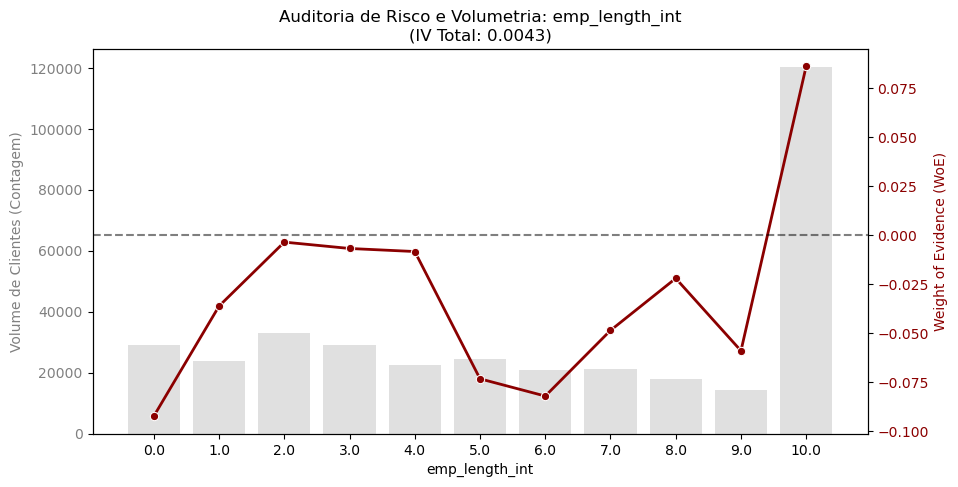

In [5]:
# 1. Unimos temporariamente o X_train e o y_train para o cálculo
df_treino_woe = X_train.join(y_train)

# 2. Parametrizamos com os nomes reais revelados pelo Raio-X
coluna_analise = 'emp_length_int'  # Variável que não foi dummificada
coluna_alvo = 'good_bad_loan'      # O nome real do seu Target

# 3. Calculamos o WoE
df_tabela_woe = calcular_woe_iv(df_treino_woe, coluna_analise, coluna_alvo)

# 4. Plotamos a auditoria visual
auditar_tendencia_woe(df_tabela_woe, coluna_analise)